In [1]:
# conda create --name pes-env python=3.11.4 numpy scipy matplotlib pyserial control ipykernel

import time
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy as sp
from SerialStream import SerialStream

In [2]:
port = "/dev/ttyUSB0"  # "COM12"
baudrate = int(2e6)

# Initialize the SerialStream object
try:
    serialStream.reset()
    print("Resetting existing serialStream object.")
except Exception as e:
    serialStream = SerialStream(port, baudrate)
    print("Creating new serialStream object.")

# Starting the stream
serialStream.start()
while serialStream.is_busy_flag():
    time.sleep(0.1)

# Accessing the data
try:
    data = serialStream.get_data()
except Exception as e:
    print("Data Stream not triggered.")
    exit()

# Save the data
filename = "data_comp_filter_00.npz"
np.savez(filename, **data)

# Load the data
loaded = np.load(filename)
data = {"time": loaded["time"], "values": loaded["values"]}

Creating new serialStream object.
SerialStream waiting for 3.00 seconds...
SerialStream started, logging 5 signals
             logging for 2.00 seconds...
             logging for 4.00 seconds...
SerialStream ended with 0.30 seconds timeout
             logged for 5.00 seconds
             measured 1255 datapoints


(0.0, 24000.000000001088)

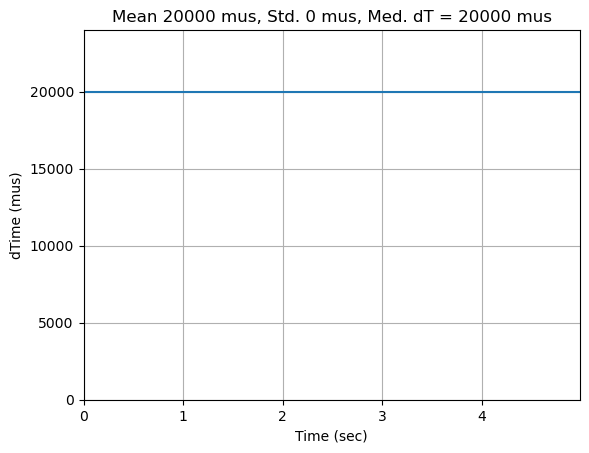

In [3]:
# Evaluate time

Ts = np.mean(np.diff(data["time"]))

plt.figure(1)
plt.plot(data["time"][:-1], np.diff(data["time"]) * 1e6)
plt.grid(True)
plt.title(f"Mean {np.mean(np.diff(data['time']) * 1e6):.0f} mus, " f"Std. {np.std(np.diff(data['time']) * 1e6):.0f} mus, " f"Med. dT = {np.median(np.diff(data['time']) * 1e6):.0f} mus")
plt.xlabel("Time (sec)")
plt.ylabel("dTime (mus)")
plt.xlim([0, data["time"][-2]])
plt.ylim([0, 1.2 * np.max(np.diff(data["time"]) * 1e6)])

(0.0, 5.0)

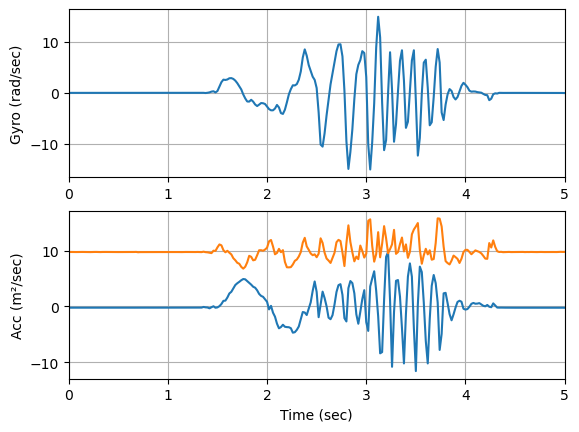

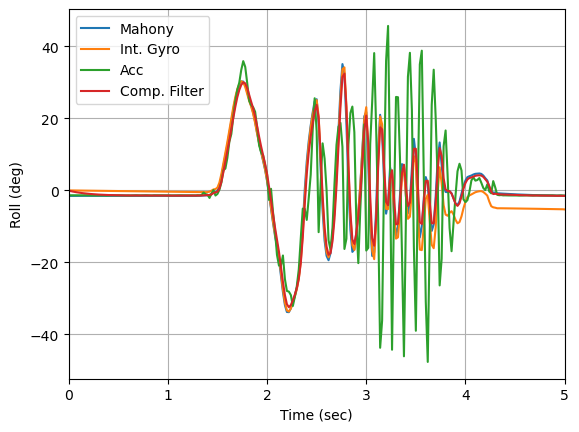

In [4]:
# Evaluate the data

# Defining the indices for the data columns
ind = {}
ind["gyro"] = 0
ind["acc"] = [1, 2]
ind["roll"] = 3

plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(data["time"], data["values"][:, ind["gyro"]])
plt.grid(True)
plt.ylabel("Gyro (rad/sec)")
plt.xlim([0, data["time"][-1]])

plt.subplot(2, 1, 2)
plt.plot(data["time"], data["values"][:, ind["acc"]])
plt.grid(True)
plt.xlabel("Time (sec)")
plt.ylabel("Acc (m²/sec)")
plt.xlim([0, data["time"][-1]])

# Roll estimates based on individual measurements
roll_gyro = np.cumsum(data["values"][:, ind["gyro"]]) * Ts
roll_acc = np.arctan2(data["values"][:, ind["acc"][0]], data["values"][:, ind["acc"][1]])

# Creating Low-Pass Filter
s = ct.tf("s")
T = 0.2
Glp_c = 1 / (T * s + 1)
Glp = ct.sample_system(Glp_c, Ts, method="tustin")
Blp = np.squeeze(Glp.num[0][0])
Alp = np.squeeze(Glp.den[0][0])

# Complementary Filter
roll_comp_filter = T * sp.signal.lfilter(Blp, Alp, data["values"][:, ind["gyro"]]) + sp.signal.lfilter(Blp, Alp, roll_acc)

plt.figure(3)
plt.plot(data["time"], np.column_stack([data["values"][:, ind["roll"]], roll_gyro, roll_acc, roll_comp_filter]) * 180 / np.pi)
plt.grid(True)
plt.xlabel("Time (sec)")
plt.ylabel("Roll (deg)")
plt.legend(["Mahony", "Int. Gyro", "Acc", "Comp. Filter"], loc="best")
plt.xlim([0, data["time"][-1]])